# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

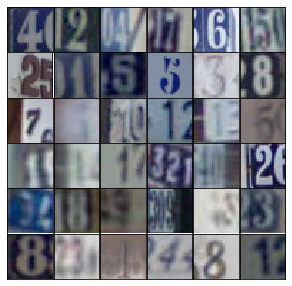

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. 
First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. 
We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
# Scale works the same as tanh
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    
    return inputs_real

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [10]:
# tf.layers.conv2d(
#     inputs, ----------
#     filters, -------------
#     kernel_size, ------------
#     strides=(1, 1), ---------------
#     padding='valid', ------------
#     data_format='channels_last', -------------> NHWC and not NCHW
#     dilation_rate=(1, 1), -------------------
#     activation=None,
#     use_bias=True, ------------------
#     kernel_initializer=None,
#     bias_initializer=tf.zeros_initializer(), ------------------
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     trainable=True, ---------------------
#     name=None,
#     reuse=None
# )

In [11]:
def generator(inputs, output_dim, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # Input layer is 32x32x3
        h1 = tf.layers.conv2d(inputs=inputs, filters=64, kernel_size=5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        # 16x16x64
        
        h2 = tf.layers.conv2d(inputs=nl1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        h3 = tf.layers.conv2d(inputs=nl2, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        nl3_vec = tf.reshape(nl3, (-1, 4*4*256))
        # First fully connected layer
        h4 = tf.layers.dense(nl3_vec, 4*4*512)
        # Reshape it to start the convolutional stack
        h4_mat = tf.reshape(h4, (-1, 4, 4, 512))
        bn4 = tf.layers.batch_normalization(h4_mat, training=training)
        nl4 = tf.maximum(alpha * bn4, bn4)
        # 4x4x512 now
        
        h5 = tf.layers.conv2d_transpose(inputs=nl4, filters=256, kernel_size=5, strides=2, padding='same')
        bn5 = tf.layers.batch_normalization(h5, training=training)
        nl5 = tf.maximum(alpha * bn5, bn5)
        # 8x8x256 now
        
        h6 = tf.layers.conv2d_transpose(inputs=nl5, filters=128, kernel_size=5, strides=2, padding='same')
        bn6 = tf.layers.batch_normalization(h6, training=training)
        nl6 = tf.maximum(alpha * bn6, bn6)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(inputs=nl6, filters=output_dim, kernel_size=5, strides=2, padding='same')        
        predictions = tf.tanh(logits)
        # 32x32x3 now
        return predictions

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

In [12]:
def discriminator(inputs, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        h1 = tf.layers.conv2d(inputs=inputs, filters=64, kernel_size=5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        # 16x16x64
        
        h2 = tf.layers.conv2d(inputs=nl1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        h3 = tf.layers.conv2d(inputs=nl2, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        nl3_vec = tf.reshape(nl3, (-1, 4*4*256))
        logits = tf.layers.dense(nl3_vec, 1)
        return logits

## Model Loss

Calculating the loss like before, nothing new here.

In [19]:
def model_loss(inputs_real, output_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param inputs_real: Images from the real dataset
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    inputs_fake = generator(inputs=inputs_real, output_dim=output_dim, alpha=alpha)
    Q = discriminator(inputs_real, alpha=alpha)
    q = discriminator(inputs_fake, alpha=alpha, reuse=True)
    d_loss = tf.reduce_mean(Q-q) 
    g_loss = -tf.reduce_mean(Q-q)
    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [21]:
class GAN:
    def __init__(self, real_size, learning_rate, alpha=0.2, beta1=0.5):
        self.input_real = model_inputs(real_dim=real_size)
        
        self.d_loss, self.g_loss = model_loss(inputs_real=self.input_real, output_dim=real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, learning_rate=learning_rate, 
                                           beta1=beta1)

Here is a function for displaying generated images.

In [22]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [23]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):

                # Run optimizers
                dloss, _ = sess.run([net.d_loss, net.d_opt], feed_dict={net.input_real: x})
                gloss, _ = sess.run([net.g_loss, net.g_opt], feed_dict={net.input_real: x})

                steps += 1
                if steps % print_every == 0:
                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Dloss: {:.4f}".format(dloss),
                          "Gloss: {:.4f}".format(gloss))
                    # Save losses to view after training
                    losses.append((dloss, gloss))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(inputs=net.input_real, output_dim=3, reuse=True, training=False),
                                   feed_dict={net.input_real: x})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')
        with open('samples.pkl', 'wb') as f:
            pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [24]:
real_size = (32,32,3)
learning_rate = 0.0002
batch_size = 128
epochs = 100
alpha = 0.2
beta1 = 0.5

tf.reset_default_graph()

# Create the network
net = GAN(real_size=real_size, learning_rate=learning_rate, alpha=alpha, beta1=beta1)

dataset = Dataset(trainset, testset)

Epoch 1/100... Dloss: 2.3920 Gloss: 5.6689
Epoch 1/100... Dloss: -1.8065 Gloss: 10.1451
Epoch 1/100... Dloss: -4.5159 Gloss: 11.0991
Epoch 1/100... Dloss: -1.6453 Gloss: 5.4925
Epoch 1/100... Dloss: 1.9560 Gloss: 2.8535
Epoch 1/100... Dloss: -0.9440 Gloss: 5.2207
Epoch 1/100... Dloss: -4.5017 Gloss: 7.5474
Epoch 1/100... Dloss: -5.6291 Gloss: 12.0276
Epoch 1/100... Dloss: -2.8650 Gloss: 10.4185
Epoch 1/100... Dloss: -6.8531 Gloss: 13.9821


/home/arasdar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1324: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


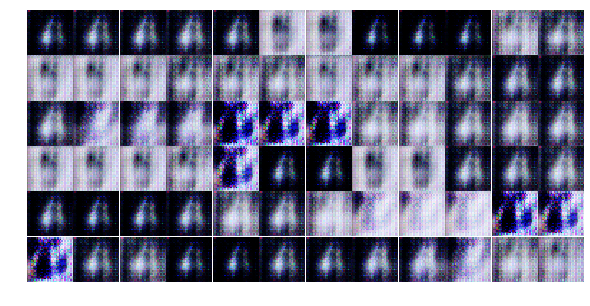

Epoch 1/100... Dloss: -6.4894 Gloss: 14.9548
Epoch 1/100... Dloss: -9.5869 Gloss: 18.4600
Epoch 1/100... Dloss: -6.0289 Gloss: 15.4327
Epoch 1/100... Dloss: -14.0689 Gloss: 24.9308
Epoch 1/100... Dloss: -13.1460 Gloss: 24.8154
Epoch 1/100... Dloss: -7.6543 Gloss: 21.4720
Epoch 1/100... Dloss: -14.2347 Gloss: 26.9473
Epoch 1/100... Dloss: -0.6448 Gloss: 14.1103
Epoch 1/100... Dloss: -9.8584 Gloss: 23.0038
Epoch 1/100... Dloss: -8.5995 Gloss: 23.0262


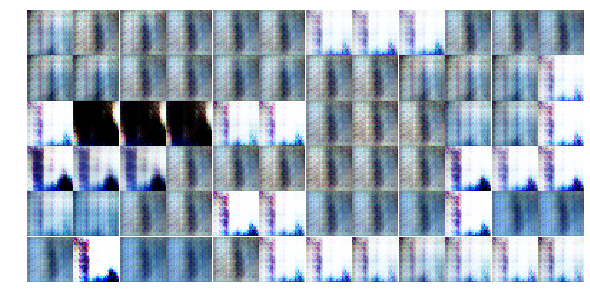

Epoch 1/100... Dloss: -17.7530 Gloss: 30.7094
Epoch 1/100... Dloss: -11.6240 Gloss: 24.8175
Epoch 1/100... Dloss: -31.5222 Gloss: 46.6087
Epoch 1/100... Dloss: -34.6168 Gloss: 49.7049
Epoch 1/100... Dloss: -53.4749 Gloss: 77.3924
Epoch 1/100... Dloss: -30.6404 Gloss: 61.3454
Epoch 1/100... Dloss: -75.6970 Gloss: 97.6362
Epoch 1/100... Dloss: -101.8083 Gloss: 84.5397
Epoch 1/100... Dloss: -105.7070 Gloss: 126.5582
Epoch 1/100... Dloss: -28.5961 Gloss: 75.2639


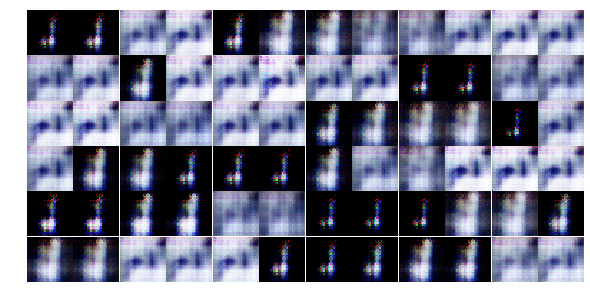

Epoch 1/100... Dloss: -26.6100 Gloss: 67.1464
Epoch 1/100... Dloss: -47.2085 Gloss: 70.6740
Epoch 1/100... Dloss: -80.8232 Gloss: 122.2800
Epoch 1/100... Dloss: -22.0847 Gloss: 56.4463
Epoch 1/100... Dloss: -53.0037 Gloss: 102.4046
Epoch 1/100... Dloss: -63.9735 Gloss: 88.4545
Epoch 1/100... Dloss: -22.0762 Gloss: 47.0566
Epoch 1/100... Dloss: -25.6835 Gloss: 57.8382
Epoch 1/100... Dloss: 15.3469 Gloss: 0.3255
Epoch 1/100... Dloss: -4.2420 Gloss: 27.7702


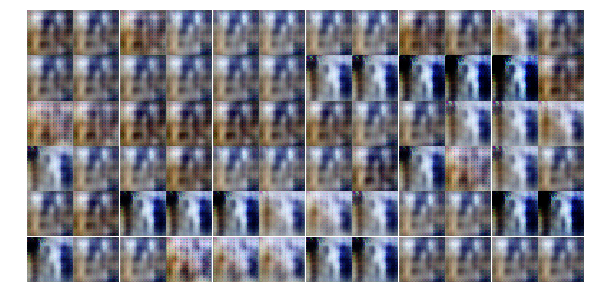

Epoch 1/100... Dloss: -1.5941 Gloss: 16.2643
Epoch 1/100... Dloss: -2.5852 Gloss: 16.0587
Epoch 1/100... Dloss: -6.8296 Gloss: 22.9232
Epoch 1/100... Dloss: 5.7926 Gloss: 12.2793
Epoch 1/100... Dloss: -5.4940 Gloss: 18.3317
Epoch 1/100... Dloss: -1.9409 Gloss: 15.1968
Epoch 1/100... Dloss: -15.8839 Gloss: 27.3855
Epoch 1/100... Dloss: -9.1419 Gloss: 26.8482
Epoch 1/100... Dloss: -1.7502 Gloss: 13.1970
Epoch 1/100... Dloss: -11.9708 Gloss: 20.3710


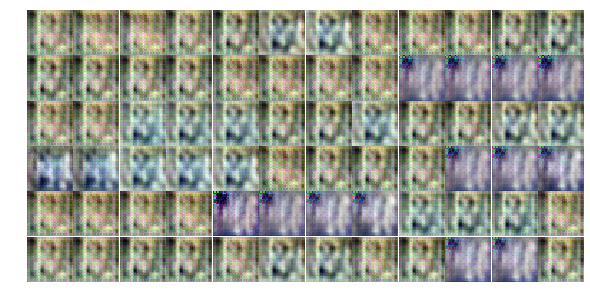

Epoch 1/100... Dloss: 5.0444 Gloss: 5.2174
Epoch 1/100... Dloss: -6.4784 Gloss: 16.7716
Epoch 1/100... Dloss: -7.6983 Gloss: 21.7072
Epoch 1/100... Dloss: -8.0455 Gloss: 23.7231
Epoch 1/100... Dloss: -6.5462 Gloss: 15.0790
Epoch 1/100... Dloss: 3.1786 Gloss: 9.8603
Epoch 1/100... Dloss: 0.5737 Gloss: 7.2157
Epoch 2/100... Dloss: -4.2388 Gloss: 10.6962
Epoch 2/100... Dloss: 2.6361 Gloss: 4.1016
Epoch 2/100... Dloss: -5.8131 Gloss: 12.4465


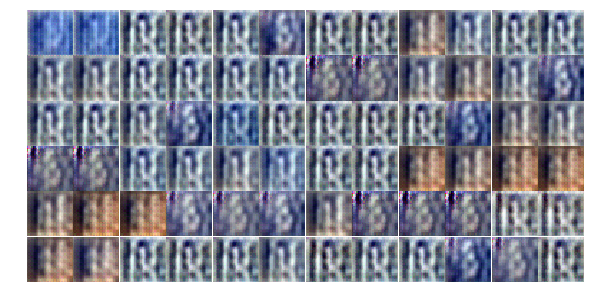

Epoch 2/100... Dloss: -3.4641 Gloss: 10.2127
Epoch 2/100... Dloss: -0.6047 Gloss: 8.4898
Epoch 2/100... Dloss: -5.5602 Gloss: 13.3106
Epoch 2/100... Dloss: 4.8827 Gloss: 3.2453
Epoch 2/100... Dloss: 2.1970 Gloss: 4.7767
Epoch 2/100... Dloss: 0.6162 Gloss: 5.2684
Epoch 2/100... Dloss: -0.7508 Gloss: 4.6269
Epoch 2/100... Dloss: -0.8828 Gloss: 7.0905
Epoch 2/100... Dloss: 2.5342 Gloss: 2.8341
Epoch 2/100... Dloss: -3.3323 Gloss: 10.5885


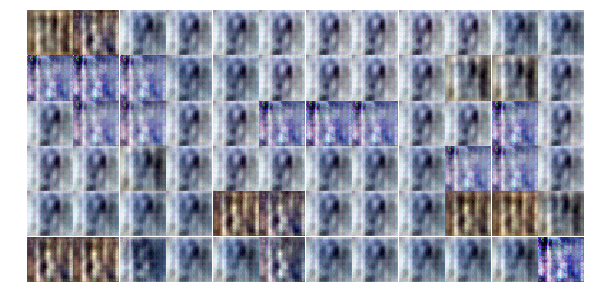

Epoch 2/100... Dloss: -5.0527 Gloss: 9.2902
Epoch 2/100... Dloss: -5.6805 Gloss: 10.9463
Epoch 2/100... Dloss: 4.8865 Gloss: -0.5240
Epoch 2/100... Dloss: -1.7746 Gloss: 6.8961
Epoch 2/100... Dloss: -0.4226 Gloss: 4.2100
Epoch 2/100... Dloss: 1.0241 Gloss: 5.7476
Epoch 2/100... Dloss: -3.4846 Gloss: 6.9652
Epoch 2/100... Dloss: -4.9084 Gloss: 14.6421
Epoch 2/100... Dloss: 2.1661 Gloss: 2.2937
Epoch 2/100... Dloss: -5.9275 Gloss: 10.3530


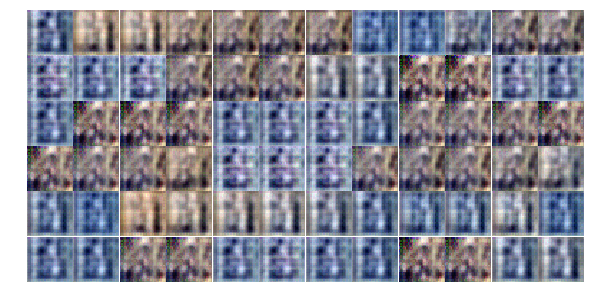

Epoch 2/100... Dloss: -3.9957 Gloss: 7.9327
Epoch 2/100... Dloss: -8.0287 Gloss: 14.2185
Epoch 2/100... Dloss: 16.4756 Gloss: -6.2501
Epoch 2/100... Dloss: 1.5363 Gloss: 3.9390
Epoch 2/100... Dloss: 0.6579 Gloss: 4.7298
Epoch 2/100... Dloss: -1.7572 Gloss: 4.7344
Epoch 2/100... Dloss: -0.7795 Gloss: 5.5560
Epoch 2/100... Dloss: -1.4400 Gloss: 4.2555
Epoch 2/100... Dloss: 5.4605 Gloss: -1.3821
Epoch 2/100... Dloss: -1.0039 Gloss: 3.2484


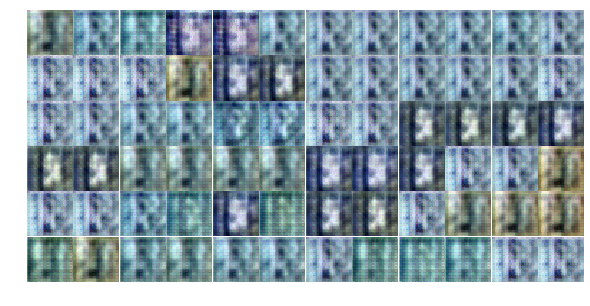

Epoch 2/100... Dloss: 2.6663 Gloss: 2.4727
Epoch 2/100... Dloss: -0.2630 Gloss: 2.6914
Epoch 2/100... Dloss: 1.3086 Gloss: 1.4064
Epoch 2/100... Dloss: -4.8327 Gloss: 7.6174
Epoch 2/100... Dloss: -1.7153 Gloss: 5.7494


In [ ]:
losses, samples = train(net=net, dataset=dataset, epochs=epochs, batch_size=batch_size, figsize=(10,5))

(57, 3) (57, 3) float32 float32


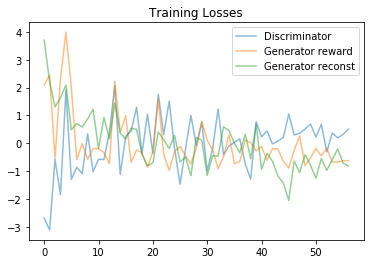

In [21]:
fig, ax = plt.subplots()
losses_ = np.array(losses)
losses_norm = (losses_ - losses_.mean(axis=0))/losses_.std(axis=0)
print(losses_.shape, losses_norm.shape, losses_norm.dtype, losses_norm.dtype)
plt.plot(losses_norm.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses_norm.T[1], label='Generator reward', alpha=0.5)
plt.plot(losses_norm.T[2], label='Generator reconst', alpha=0.5)
plt.title("Training Losses")
plt.legend()

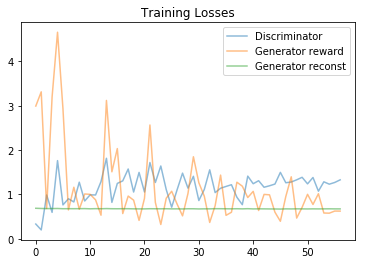

In [22]:
fig, ax = plt.subplots()
losses_ = np.array(losses)
plt.plot(losses_.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses_.T[1], label='Generator reward', alpha=0.5)
plt.plot(losses_.T[2], label='Generator reconst', alpha=0.5)
plt.title("Training Losses")
plt.legend()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


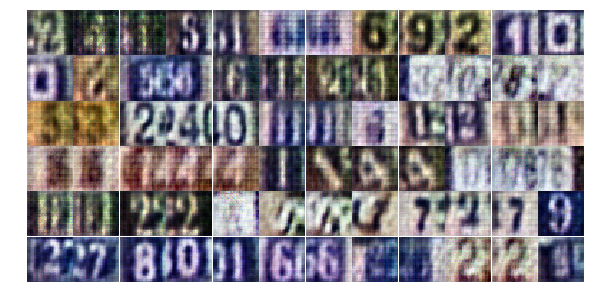

In [23]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

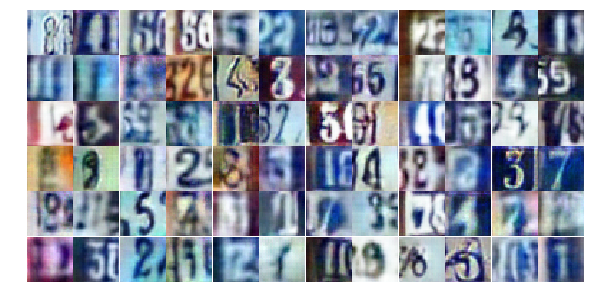

In [19]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))